In [ ]:
!pip install torch_geometric
!pip install torch_sparse
!pip install torch_scatter

In [273]:
import numpy as np
from torch_geometric.datasets import Planetoid
from torch import nn 
import torch.nn.functional as F
n = 2708
c = 7

In [272]:
def calc_transition_mat(data,sigma=2):
    D = torch.Tensor(n,n)
    X = data.x
    for i in range(n):
        for j in range(n):
            D[i][j] = torch.norm(X[i]-X[j])
    W = torch.exp(-torch.square(D)/(sigma**2) )
    T = F.normalize(W,p=1,dim=0)
    return T

In [274]:
def label_prop(T,train_size_per_class,max_iters=200):
    
    test_size = n - c*train_size_per_class
    dataset = Planetoid(root='~/workspace/data/Cora', name='Cora',split='random',num_train_per_class=train_size_per_class,num_val=0, num_test=test_size)
    data = dataset[0]

    Y_ = F.one_hot(data.y[data.train_mask])
    Y_ = Y_.type(torch.FloatTensor)
    Y = torch.zeros(n,c)
    Y[data.train_mask]= Y_
    Y_prev = Y 
    for i in range(max_iters):
        Y_cur = torch.matmul(T,Y_prev)
        pred = torch.argmax(Y_cur,dim=1)
        Y_cur[data.train_mask]= Y_
        Y_cur =  F.normalize(Y_cur,p=1,dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        #print(acc)
        d = torch.norm(Y_cur-Y_prev)
        if(d<=1e-4):
            break
        Y_prev = Y_cur
    return acc 
label_prop(T,50)

0.5258693808312129

In [275]:
lst_ts = np.array([20,40,80,120,160,200])
trails = 10
all_outs = []
for ts in lst_ts:
    out = []
    for t in range(trails):
        acc = label_prop(T,ts)
        #print(t,ts,acc)
        out.append(acc)
    all_outs.append(out)

[0.24373053 0.42454695 0.60796089 0.67457173 0.71429471 0.73470948] [0.08441222 0.07761855 0.03949409 0.0199219  0.01576837 0.02131643]


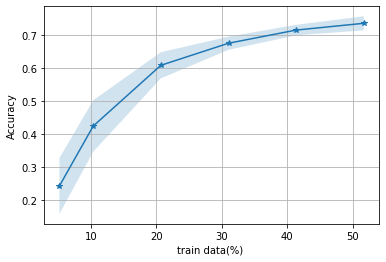

In [277]:
y = np.mean(all_outs,axis=1)
y_err = np.std(all_outs,axis=1)
print(y,y_err)
x_ticks = (lst_ts*c*100 )/n
plt.plot(x_ticks,y,marker='*')
plt.fill_between(x_ticks,y-y_err,y+y_err,alpha=0.2)
plt.ylabel('Accuracy')
plt.xlabel('train data(%) ')
plt.grid()